<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.clustering-and-anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# We resort to a third party library to plot silhouette diagrams
! pip install yellowbrick
from yellowbrick.cluster import SilhouetteVisualizer

**Goal**: 
Find fraudolent credit card transactions

**Dataset**:
* From [DataHub](https://datahub.io/machine-learning/creditcard)
* Anonimized transactions
* Features have no precise meaning: obtained via Principal Component Analysis (PCA)
* Ground truth: transactions labeled as normal/anomaly

In [35]:
! wget https://datahub.io/machine-learning/creditcard/r/creditcard.csv

--2020-03-31 13:43:09--  https://datahub.io/machine-learning/creditcard/r/creditcard.csv
Resolving datahub.io (datahub.io)... 104.18.49.253, 104.18.48.253, 2606:4700:3031::6812:30fd, ...
Connecting to datahub.io (datahub.io)|104.18.49.253|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv [following]
--2020-03-31 13:43:10--  https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 104.18.49.253, 104.18.48.253, 2606:4700:3033::6812:31fd, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|104.18.49.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151114991 (144M) [text/csv]
Saving to: ‘creditcard.csv.3’

creditcard.csv.3    100%[===================>] 144.11M  79.0MB/s    in

In [36]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,'0'


In [37]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [38]:
df['Class'].value_counts()

'0'    284315
'1'       492
Name: Class, dtype: int64

The anomalies are the minority.

Remove the time, since it has no meaning for discovering anomalies for us.

In [0]:
df = df.drop('Time', axis=1)

In unsupervised approaches, the label is not used

In [0]:
X = df.drop('Class', axis=1)

All the methods we will use, except iForests, performs best if the dataset is scaled

In [0]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means clustering

In [0]:
K =3
model = KMeans(n_clusters=K, random_state=3)
clusters = model.fit_predict(X_scaled)

The array `clusters` contains the cluster id of each sample

In [43]:
clusters[0:5]

array([1, 1, 1, 1, 1], dtype=int32)

Check how many elements per cluster

(array([ 20198.,      0.,      0.,      0.,      0., 259408.,      0.,
             0.,      0.,   5201.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

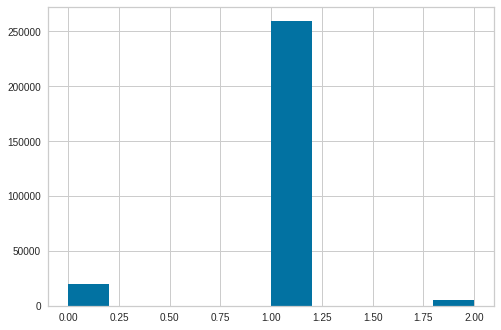

In [44]:
plt.hist(clusters)

(0.0, 284847.0)

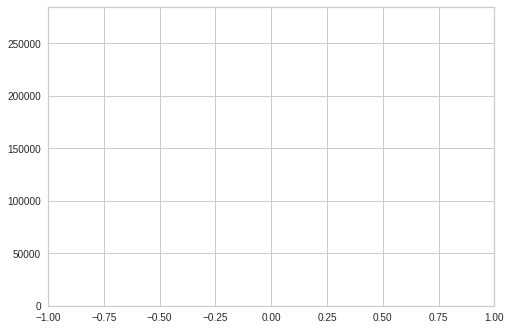

In [45]:
# Inspired by https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

fig, (ax1) = plt.subplots()

# The silhouette coefficient can range from -1, 1
ax1.set_xlim([-1, 1])

# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (K + 1) * 10])




If you try to compute the silhouette score with ordinary `sklearn` functions, it is extremely slow.

Recall that you need to compute the distances between all samples, i.e.

In [46]:
print("Distances to be computed: ", "{:e}".format( X_scaled.shape[0]**2) )

Distances to be computed:  8.111503e+10


We will thus used an alternative implementation from [Alexandre Abraham](https://gist.github.com/AlexandreAbraham/5544803).

In [47]:
! wget https://gist.githubusercontent.com/AlexandreAbraham/5544803/raw/221aa797cdbfa9e9f75fc0aabb2322dcc11c8991/unsupervised_alt.py

import unsupervised_alt

--2020-03-31 13:43:32--  https://gist.githubusercontent.com/AlexandreAbraham/5544803/raw/221aa797cdbfa9e9f75fc0aabb2322dcc11c8991/unsupervised_alt.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17093 (17K) [text/plain]
Saving to: ‘unsupervised_alt.py.1’

unsupervised_alt.py 100%[===================>]  16.69K  --.-KB/s    in 0.01s   

2020-03-31 13:43:32 (1.33 MB/s) - ‘unsupervised_alt.py.1’ saved [17093/17093]



SyntaxError: ignored

In [0]:
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X_scaled, clusters)




In [0]:
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_scaled, clusters)